# Импорт библиотек

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Загрузка данных

(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

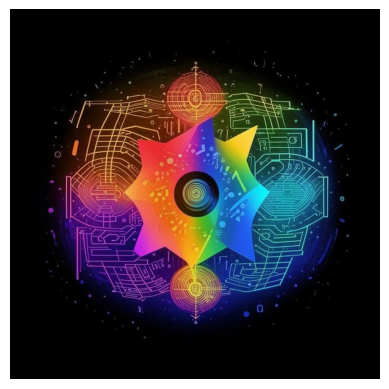

In [13]:
image_path = 'tipovikmatan.jpg'
color_image = cv2.imread(image_path)
color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
plt.imshow(color_image)
plt.axis('off')

# Размеры изображения

In [14]:
height, width, channels = color_image.shape
print(f"Размеры изображения: {width}x{height}, Каналы: {channels}")

Размеры изображения: 640x640, Каналы: 3


In [15]:
r_channel = color_image[:, :, 0]  # Красный канал
g_channel = color_image[:, :, 1]  # Зеленый канал
b_channel = color_image[:, :, 2]  # Синий канал

# Пространственные области изображения по отдельности

(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

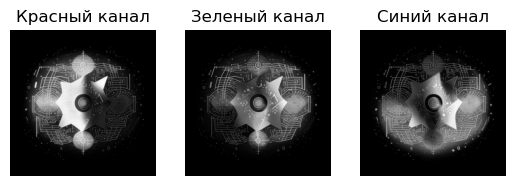

In [16]:
plt.subplot(2, 3, 1)
plt.imshow(r_channel, cmap='gray')
plt.title('Красный канал')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(g_channel, cmap='gray')
plt.title('Зеленый канал')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(b_channel, cmap='gray')
plt.title('Синий канал')
plt.axis('off')

# Парные комбинации пространственных областей изображения

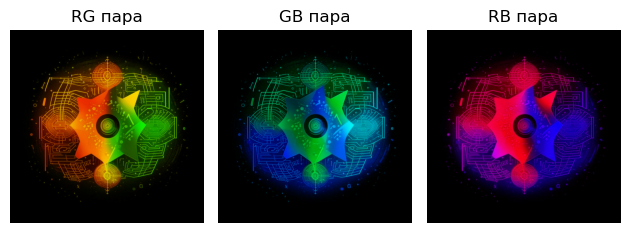

In [17]:
rg_pair = np.stack((r_channel, g_channel, np.zeros_like(r_channel)), axis=-1)
gb_pair = np.stack((np.zeros_like(g_channel), g_channel, b_channel), axis=-1)
rb_pair = np.stack((r_channel, np.zeros_like(b_channel), b_channel), axis=-1)

plt.subplot(2, 3, 4)
plt.imshow(rg_pair)
plt.title('RG пара')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(gb_pair)
plt.title('GB пара')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(rb_pair)
plt.title('RB пара')
plt.axis('off')

plt.tight_layout()
plt.show()

# Серое изображение

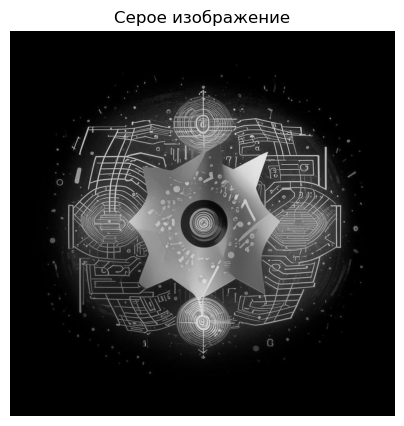

In [18]:
gray_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(5, 5))
plt.imshow(gray_image, cmap='gray')
plt.title('Серое изображение')
plt.axis('off')
plt.show()

# Графики изменения частоты каналов

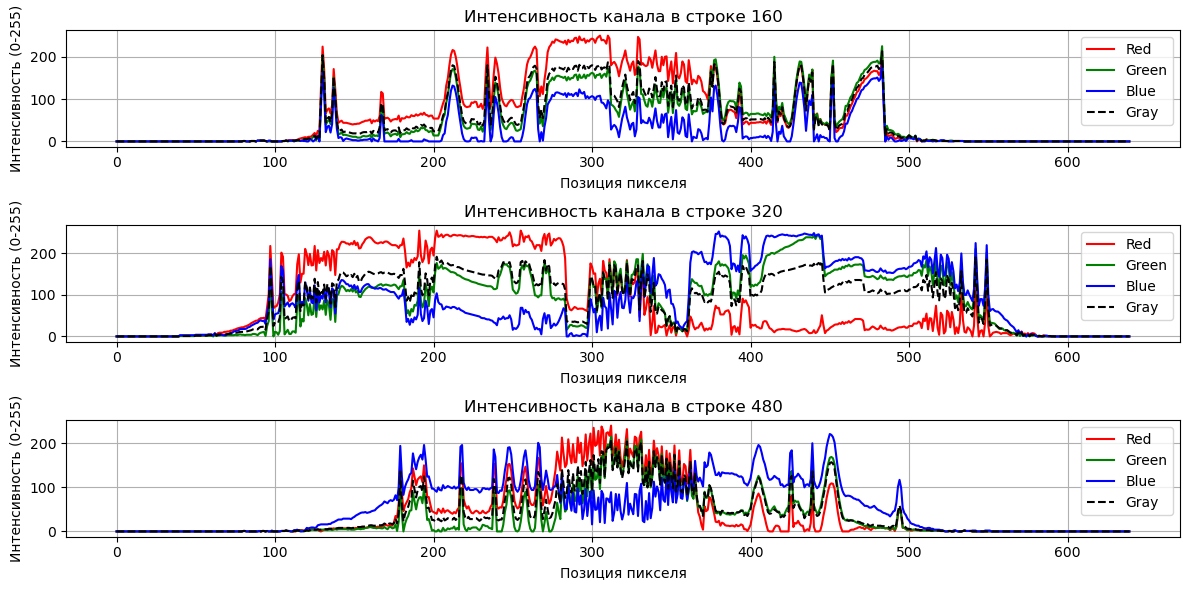

In [19]:
selected_rows = [height // 4, height // 2, 3 * height // 4]
plt.figure(figsize=(12, 6))

for i, row in enumerate(selected_rows):
    r_values = color_image[row, :, 0]
    g_values = color_image[row, :, 1]
    b_values = color_image[row, :, 2]
    gray_values = gray_image[row, :]

    plt.subplot(3, 1, i + 1)
    plt.plot(r_values, label='Red', color='r')
    plt.plot(g_values, label='Green', color='g')
    plt.plot(b_values, label='Blue', color='b')
    plt.plot(gray_values, label='Gray', color='k', linestyle='--')
    plt.title(f'Интенсивность канала в строке {row}')
    plt.xlabel('Позиция пикселя')
    plt.ylabel('Интенсивность (0-255)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [28]:
def convolve(image, kernel):
    """
    Применяет свертку к изображению с заданным ядром.
    image: 2D numpy array (изображение)
    kernel: 2D numpy array (ядро свертки)
    :return:
    """
    h, w = image.shape
    kh, kw = kernel.shape

    pad_h = kh // 2
    pad_w = kw // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)

    output = np.zeros_like(image, dtype=float)

    for i in range(h):
        for j in range(w):
            output[i, j] = np.sum(kernel * padded_image[i:i + kh, j:j + kw])

    return output


def threshold_filter(image, thresh=128):
    """
    Применяет пороговую фильтрацию к изображению.
    image: 2D numpy array (0–255)
    thresh: порог (0–255)
    """
    return np.where(image >= thresh, 255, 0).astype(np.uint8)


def median_filter(image, ksize=3):
    """
    Применяет медианный фильтр к изображению.
    image: 2D numpy array
    ksize: нечётный размер окна
    """
    pad = ksize // 2
    padded = np.pad(image, pad, mode='constant', constant_values=0)
    out = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            window = padded[i:i + ksize, j:j + ksize]
            out[i, j] = np.median(window)
    return out.astype(image.dtype)


def gaussian_kernel(ksize=5, sigma=1.0):
    """
    Создает гауссовский фильтр ядра размера ksize×ksize с заданным sigma.
    ksize: размер ядра (должен быть нечётным числом)
    sigma: стандартное отклонение гауссовского распределения
    """
    ax = np.arange(-ksize // 2 + 1, ksize // 2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
    kernel /= np.sum(kernel)
    return kernel


def gaussian_filter(image, ksize=5, sigma=1.0):
    """
    Применяет гауссовский фильтр к изображению.
    image: 2D numpy array
    ksize: размер ядра (должен быть нечётным числом)
    sigma: стандартное отклонение гауссовского распределения
    """
    kern = gaussian_kernel(ksize, sigma)
    return convolve(image, kern)


def box_blur(image, ksize=3):
    """
    Применяет блочный фильтр (среднее) к изображению.
    image: 2D numpy array
    ksize: размер ядра (должен быть нечётным числом)
    """
    kern = np.ones((ksize, ksize), dtype=float) / (ksize * ksize)
    return convolve(image, kern)


def sobel_filter(image):
    """
    Применяет фильтр Собеля к изображению для выделения границ.
    image: 2D numpy array (0–255)
    """
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=float)
    sobel_y = sobel_x.T
    gx = convolve(image, sobel_x)
    gy = convolve(image, sobel_y)
    # magnitude и нормировка в 0–255
    mag = np.hypot(gx, gy)
    mag = mag / mag.max() * 255
    return mag.astype(np.uint8)


# Искаженное изображение после свертки

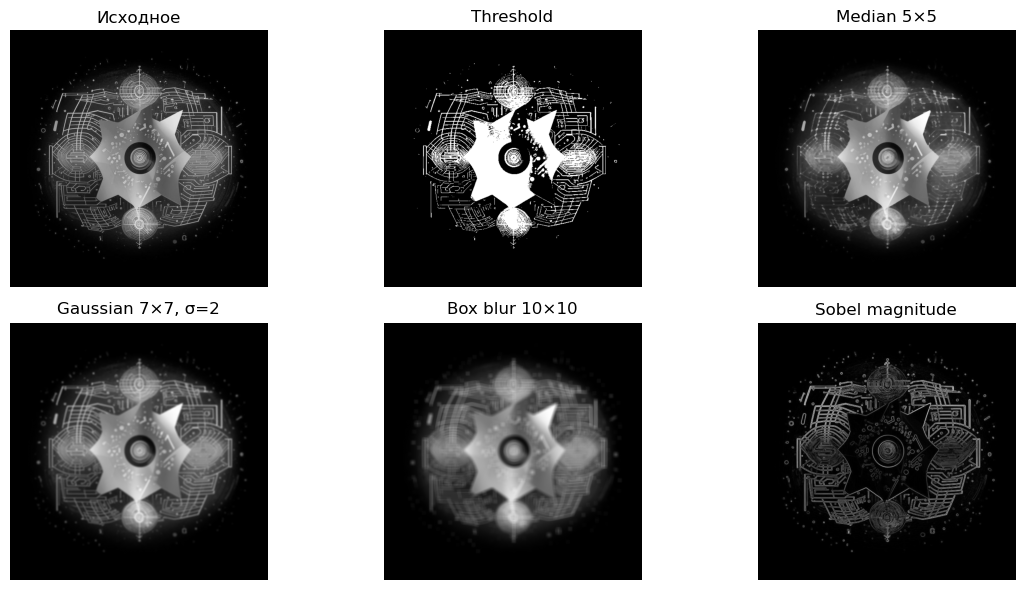

In [29]:
# Порог
th = threshold_filter(gray_image, thresh=100)

# Медианный (5×5)
med = median_filter(gray_image, ksize=5)

# Гаусс (7×7, sigma=2)
gau = gaussian_filter(gray_image, ksize=7, sigma=2.0)

# Box blur (10×10)
box = box_blur(gray_image, ksize=10)

# Sobel
sob = sobel_filter(gray_image)

plt.figure(figsize=(12, 6))
for i, (img, title) in enumerate([
    (gray_image, "Исходное"),
    (th, "Threshold"),
    (med, "Median 5×5"),
    (gau, "Gaussian 7×7, σ=2"),
    (box, "Box blur 10×10"),
    (sob, "Sobel magnitude")
]):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()